In [120]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
import sys
import pandas as pd
import seaborn as sns
import networkx as nx
import yaml
import os
from networkx.algorithms import approximation as nx_approx
from tqdm.notebook import tqdm
from copy import deepcopy
# Adding path to module
sys.path.append("../")
# picture path
PICS = '../pics/'

# Module imports
from contagion import Contagion, config
from contagion.config import _baseconfig
from contagion.plotting import plot_infection_history


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
100000 * 0.004

400.0

In [163]:
cpp_config = {
    "DaysBackwardTrace": 14, 
    "TestPositiveProbability": 0.9, 
    "OutputPrefix": "CovidMC_1346", 
    "AppProbability": 1.0, 
    "DaysToTestResult": 0, 
    "FalsePositiveRate": 0.01, 
    "NDays": 500, 
    "SymptomProbability": 0.6, 
    "SocialDistancingFactor": 1.0, 
    "SocialDistancingTo": 99999, 
    "BackwardTracing": True, 
    "dTTest": 5, 
    "PeopleMetPerDay": 10.0, 
    "DaysInQuarantine": 14, 
    "TraceUninfected": True, 
    "AsymptomaticTransmissionScaling": 1.0, 
    "StartTracingTestingInfectedFraction": 0.004, 
    "SocialDistancingFrom": 99999, 
    "TransmissionProbability": 0.0287, 
    "NPersons": 100000, 
    "TracingOrder": 1, 
    "IncubationPeriod": {
        "mu": 0, 
        "beta": 2.44, 
        "gamma": 3.06
    }, 
    "TestThreshold": 0.01, 
    "tracingEfficiency": 1.0, 
    "SocialDistancingMaxPeople": 60, 
    "Infectivity": {
        "mu": -2.42, 
        "beta": 1.56, 
        "gamma": 2.08
    }, 
    "TracingDelay": 0, 
    "ReportingProbability": 1.0
}

In [148]:
my_config = dict(_baseconfig)
my_config["general"]["random state seed"] = 6
my_config["general"]["track graph history"] = True
my_config["general"]["debug level"] = 50
my_config["general"]["trace spread"] = True
my_config["population"]["population class"] = "NetworkXPopulation"
#my_config["population"]["population class"] = "HomogeneousPopulation"
my_config["population"]["social circle interactions pdf"]["mean"] =  cpp_config["PeopleMetPerDay"]
my_config["population"]["social circle interactions pdf"]["sd"] =  1
my_config["population"]["social circle pdf"]["mean"] =  cpp_config["PeopleMetPerDay"]
my_config["population"]["social circle pdf"]["sd"] =  1


my_config["measures"]["contact tracing"] = True
my_config["measures"]["tracked fraction"] = 0 #cpp_config["AppProbability"]
my_config["measures"]["second order"] = cpp_config["TracingOrder"] == 2
my_config["measures"]["backtrack length"] = cpp_config["DaysBackwardTrace"]
my_config["measures"]["track uninfected"] = cpp_config["TraceUninfected"]
my_config["measures"]["quarantine"] = True
my_config["measures"]["report symptomatic"] = True
my_config["measures"]["quarantine duration"] = cpp_config["DaysInQuarantine"]
my_config["measures"]["testing"] = True
my_config["measures"]["time until test"] = 1
my_config["measures"]["time until result"] = 1# cpp_config["DaysToTestResult"]
my_config["measures"]["test true positive rate"] = cpp_config["TestPositiveProbability"]

my_config["scenario"]["sim_length"] = 500
my_config['infection']['infected'] = 1
my_config["infection"]["infection probability pdf"]["max_val"] = 0.069
my_config['infection']["hospitalization probability pdf"]['mean'] = 0.0001
my_config['infection']["hospitalization probability pdf"]['sd'] = 0.00001

my_config['infection']['will have symptoms prob pdf']['mean'] = cpp_config["SymptomProbability"]
my_config['infection']['will have symptoms prob pdf']['sd'] = 0.01




my_config["population"]["random interactions pdf"]["mean"] = 0.0001
my_config["population"]["random interactions pdf"]["sd"] = 0.0001
my_config["population"]["random interactions intensity pdf"]["mean"] = 0.0001
my_config["population"]["random interactions intensity pdf"]["sd"] = 0.0001


my_config["population"]["population size"] = cpp_config["NPersons"]

my_config["population"]["nx"]["func"] = "lfr_ba"
my_config["population"]["nx"]["kwargs"] = {
                "m": 3,
                "tau": 1.2,
                "mu": 0.1,
                "min_community": 13,
                #"max_community": 40,
                "max_iters": 4000,
                "tolerance": 0.1,
                "pref_attach": True
            }
my_config["population"]["nx"]["inter freq pdf"] = {
                "class": "Gamma",
                "mean": cpp_config["PeopleMetPerDay"],
                "sd": 1
            }
my_config["population"]["nx"]["intra freq pdf"] = { 
                "class": "Gamma",
                "mean": cpp_config["PeopleMetPerDay"],
                "sd": 1
            }
my_config["population"]["random interactions pdf"] = {"class": "Delta", "mean": 0.001}
my_config["scenario"]["class"] = "LateMeasures"
my_config["scenario"]["start_measures_inf_frac"] = cpp_config["StartTracingTestingInfectedFraction"]


In [149]:
yaml.dump(my_config, open("test_social_graph_cpp_params.yaml", "w"))

In [150]:
def sim_config(conf, n=10):
    if not os.path.exists(conf["population"]["population storage"]):
        conf["population"]["store population"] = True
        #my_config["population"]["population storage"] = "1E6_lfr_ba.pickle"
        conf["population"]["re-use population"] = False
        contagion = Contagion(conf)
    conf["population"]["re-use population"] = True
    conf["population"]["store population"] = False
    
    results = []
    for i in range(n):
        conf["general"]["random state seed"] = i
        contagion = Contagion(conf)
        contagion.sim()
        results.append(pd.DataFrame(contagion.statistics))
    return results

    

In [151]:
conf_1 = deepcopy(my_config)
conf_1["population"]["population class"] = "HomogeneousPopulation"
conf_1["population"]["population storage"] = "1E6_homog.pickle"

conf_2 = deepcopy(my_config)
conf_2["population"]["population class"] = "NetworkXPopulation"
conf_2["population"]["nx"]["func"] = "lfr_ba"
conf_2["population"]["nx"]["kwargs"]["m"] = 3
conf_2["population"]["population storage"] = "1E6_lfr_ba_m3.pickle"

conf_3 = deepcopy(my_config)
conf_3["population"]["population class"] = "NetworkXPopulation"
conf_3["population"]["nx"]["func"] = "lfr_ba"
conf_3["population"]["nx"]["kwargs"]["m"] = 4
conf_3["population"]["population storage"] = "1E6_lfr_ba_m4.pickle"

conf_4 = deepcopy(my_config)
conf_4["population"]["population class"] = "NetworkXPopulation"
conf_4["population"]["nx"]["func"] = "lfr_ba"
conf_4["population"]["nx"]["kwargs"]["m"] = 5
conf_4["population"]["population storage"] = "1E6_lfr_ba_m5.pickle"

conf_5 = deepcopy(my_config)
conf_5["population"]["population class"] = "NetworkXPopulation"
conf_5["population"]["nx"]["func"] = "hierarchical_lfr_ba"
conf_5["population"]["nx"]["kwargs"]["m"] = 3
conf_5["population"]["nx"]["kwargs"]["mu_hier"] = 0.3
conf_5["population"]["nx"]["kwargs"]["tau_graphs"]= 3
conf_5["population"]["nx"]["kwargs"]["min_graph"] = 10000
conf_5["population"]["nx"]["kwargs"]["max_graph"] = 200000
conf_5["population"]["nx"]["kwargs"]["max_iters"] = 10000
conf_5["population"]["population storage"] = "1E6_hier_lfr_ba_m3_taug3.pickle"

conf_6 = deepcopy(my_config)
conf_6["population"]["population class"] = "NetworkXPopulation"
conf_6["population"]["nx"]["func"] = "lfr_ba"
conf_6["population"]["nx"]["kwargs"]["m"] = 5
conf_6["population"]["nx"]["kwargs"]["mu"] = 0.5
conf_6["population"]["population storage"] = "1E6_lfr_ba_m5_mu_0.5.pickle"

configs = [conf_1, conf_2, conf_3, conf_4, conf_5, conf_6]



In [165]:
all_results = []
for config in configs:
    all_results.append(sim_config(config, 5))
    

In [171]:
sum_stats = []
for res in all_results:
    tot_infs = []
    for result in res:
        tot_inf_index = min(365, len(result["is_infected"])-1)
        tot_infs.append((result["is_infected"][tot_inf_index]+result["is_recovered"][tot_inf_index]+result["is_recovering"][tot_inf_index]))
    sum_stats.append(tot_infs)

In [175]:
for sstats in sum_stats:
    print(sstats)

[27040, 26087, 27922, 26393, 26210]
[15, 3747, 2, 1, 5]
[10312, 8984, 4, 9394, 4]
[20109, 19177, 19342, 4, 2]
[5578, 1, 7035, 1, 5585]
[23152, 22282, 1, 1, 2]


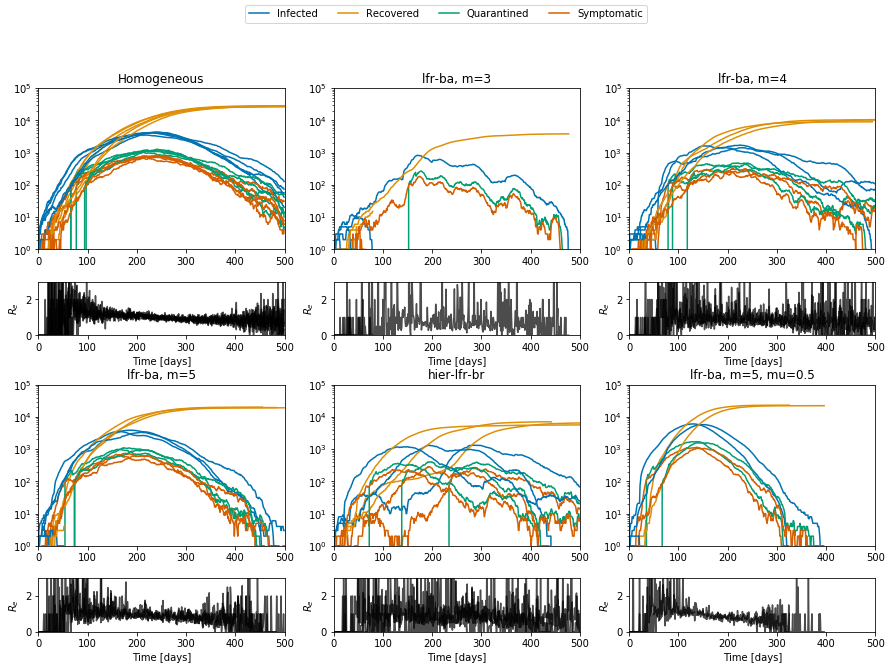

In [166]:
fig = plt.figure(figsize=(15, 10))
colors = sns.color_palette("colorblind", 4)
labels = ["Homogeneous", "lfr-ba, m=3", "lfr-ba, m=4", "lfr-ba, m=5", "hier-lfr-br", "lfr-ba, m=5, mu=0.5"]

for i, (res, label) in enumerate(zip(all_results, labels)):
    
    gs_spec = gs[i // 3, i % 3]
    
    gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs_spec, height_ratios=[3, 1], hspace=0.3)
    ax = fig.add_subplot(gs2[0])
    ax2 = fig.add_subplot(gs2[1])
    
    
    for result in res:
        ax.plot(result["is_infected"], color=colors[0])
        ax.plot(result["is_recovered"], color=colors[1])
        ax.plot(result["is_quarantined"], color=colors[2])
        ax.plot(result["is_symptomatic"], color=colors[3])
        ax2.plot(result["Re"], color="k", alpha=0.7)
    ax2.set_xlabel("Time [days]")
    ax.set_title(label)
    ax.set_ylim(1, 1E5)
    ax.set_xlim(0, 500)
    ax.set_yscale("log")
    
    ax2.set_xlim(0, 500)
    ax2.set_ylim(0, 3)
    ax2.set_ylabel("$R_e$")
    

    
labels = ["Infected", "Recovered", "Quarantined", "Symptomatic"]
proxies = [Line2D([], [], color=color) for color in colors]
fig.legend(proxies, labels, loc="upper center", ncol=4)
plt.savefig(os.path.join(PICS, "social_graph_comp.png"), dpi=150)

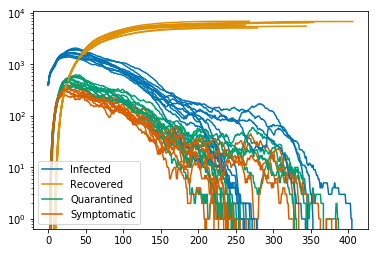